# **Supervised Learning on Iris Dataset**

In this assignment, we apply different supervised learning algorithms to classify the Iris dataset.

Algorithms covered:
- Q1: Naive Bayes
- Q2: Decision Trees
- Q3: k-Nearest Neighbors, Logistic Regression, Support Vector Machines

In [61]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Custom scripts
# import sys
# sys.path.append("../scripts")
# from naiveBayes import naiveBayes
# import BasicTree

# Sklearn classifiers
from sklearn.datasets import load_iris, make_friedman1
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, _tree



In [51]:
# Define the naive Bayes function
def naiveBayes(classes, learner, parameterised_function, train_data):
    """
    Train a naive Bayes model by fitting a 
    parameterised distribution to each feature within each class, 
    assuming independence between features.

    Args:
        classes (list): List of possible class labels.
        learner (function): Function that estimates parameters from training data 
                            (e.g., mean and std for Gaussian).
        parameterised_function (function): Function that takes parameters and 
                                           returns a probability density function.
        train_data (np.ndarray): Training data with features in columns and 
                                 class labels in the last column.

    Returns:
        dict: A dictionary of functions, where each function g[class_value](test_data) 
              computes the unscaled likelihood for a batch of test points belonging to that class.
    """
    f = {}           # feature-wise likelihood functions for each class
    parameters = {}  # learned parameters per feature per class
    g = {}           # class likelihood functions

    for class_value in classes:
        # Store parameters and functions for each feature of this class
        parameters[class_value] = {}
        f[class_value] = {}

        # Extract only training samples belonging to the current class
        train_x = train_data[train_data[:, -1] == class_value][:, :-1]

        # Learn distribution parameters for each feature
        for feature in range(train_x.shape[1]): 
            parameters[class_value][feature] = learner(train_x[:,feature])
            f[class_value][feature] = parameterised_function(parameters[class_value][feature])

        # Define a class-specific likelihood function
        def create_g(class_value):     
            def g(test_data):
                # For each test point, compute likelihood of each feature independently
                unscaled_feature_likelihoods = np.array([
                    [f[class_value][feature](test_data[point, feature]) 
                     for feature in range(test_data.shape[1])]
                    for point in range(test_data.shape[0])
                ])
                # Multiply feature likelihoods (independence assumption)
                unscaled_point_likelihood = np.prod(unscaled_feature_likelihoods, axis=1).reshape(-1, 1)
                return unscaled_point_likelihood
            return g
        
        # Store the likelihood function for this class
        g[class_value] = create_g(class_value)

    return g



## **Question 1.1**
### **What does the naive Bayes classifier actually return?**
The naive Bayes classifier returns, for each class, a function that can evaluate the unscaled likelihood of a test point belonging to that class. In other words, it doesn’t directly give you probabilities, but it gives you a way to score new points by multiplying together feature-wise likelihoods under the independence assumption. The class with the highest score is then taken as the prediction.

### **What do the functions do that are defined inside the main function?**
The functions defined inside act as class-specific likelihood calculators. Each one takes in test data and applies the learnt feature distributions (from the training phase) to compute how likely the test point is if it were generated by that class. They are essentially wrappers that fix the class context and then process arbitrary test points.

### **What is the role of the inputs to the naiveBayes function, in particular the learner and the parameterised function?**
The `learner` is the procedure that estimates parameters from the training data for a single feature of a given class, for example, computing the mean and variance if we assume Gaussian features. The `parameterised_function` then takes those parameters and returns an actual density function that can score feature values. Together, these inputs define the modelling choice: `learner` extracts parameters, and `parameterised_function` turns them into usable feature-wise likelihood functions.

## **Question 1.2: Where does the independence assumption made by the Naive Bayes approach come into the calculation?**
The independence assumption appears when the classifier multiplies together the feature-wise likelihoods. Instead of modelling the full joint distribution of all features at once, it assumes each feature contributes independently. That’s why, in the code, the per-feature likelihood values are computed separately and then combined using a product across features.

## **Question 1.3: What class of functions does the parameterised function in the example represent?**
In the given example, the parameterised function represents Gaussian density functions. Each feature within a class is modelled as a normal distribution with its own mean and standard deviation. More generally, the parameterised function defines the family of distributions used to describe feature likelihoods (Gaussian in this case), but it could just as well be Bernoulli, multinomial, or any other parametric density depending on the data.


In [52]:
# Load Iris dataset with first column as index
iris = pd.read_csv("../data/iris.csv", index_col=0)

# === Column headers, dtypes, missing values ===
col_info = pd.DataFrame({
    "Column": iris.columns,
    "Dtype": iris.dtypes.astype(str),
    "Missing": iris.isnull().sum().values
})

print(" Column Overview")
print(tabulate(col_info, headers="keys", tablefmt="psql"))

# === Quick statistical summary ===
print("\n Summary Statistics")
print(tabulate(iris.describe().reset_index(), headers="keys", tablefmt="psql"))

# === Value counts for Species (categorical) ===
print("\n Species Value Counts")
print(tabulate(iris['Species'].value_counts().reset_index().rename(columns={'index': 'Species', 'Species': 'Count'}), headers="keys", tablefmt="psql"))

print("\n First 5 Rows of the Dataset")
print(tabulate(iris.head(), headers="keys", tablefmt="psql"))



 Column Overview
+--------------+--------------+---------+-----------+
|              | Column       | Dtype   |   Missing |
|--------------+--------------+---------+-----------|
| Sepal.Length | Sepal.Length | float64 |         0 |
| Sepal.Width  | Sepal.Width  | float64 |         0 |
| Petal.Length | Petal.Length | float64 |         0 |
| Petal.Width  | Petal.Width  | float64 |         0 |
| Species      | Species      | object  |         0 |
+--------------+--------------+---------+-----------+

 Summary Statistics
+----+---------+----------------+---------------+----------------+---------------+
|    | index   |   Sepal.Length |   Sepal.Width |   Petal.Length |   Petal.Width |
|----+---------+----------------+---------------+----------------+---------------|
|  0 | count   |     150        |    150        |       150      |    150        |
|  1 | mean    |       5.84333  |      3.05733  |         3.758  |      1.19933  |
|  2 | std     |       0.828066 |      0.435866 |         1.7

## **Question 1.4** 
We train a Naive Bayes classifier on the Iris dataset, using a train/test split to evaluate its performance on unseen data.

In [53]:
# Features (X) and target (y)
X = iris.drop(columns=["Species"])
y = iris["Species"]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Gaussian Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predictions
y_pred = nb.predict(X_test)

# Accuracy
print("Accuracy")
print(round(accuracy_score(y_test, y_pred), 4))

# Classification Report
print("\n Classification Report")
report = classification_report(y_test, y_pred, output_dict=True)
print(tabulate(pd.DataFrame(report).T, headers="keys", tablefmt="psql"))

# Confusion Matrix
print("\n Confusion Matrix")
cm = confusion_matrix(y_test, y_pred, labels=nb.classes_)
cm_df = pd.DataFrame(cm, index=nb.classes_, columns=nb.classes_)
print(tabulate(cm_df, headers="keys", tablefmt="psql"))

Accuracy
0.9667

 Classification Report
+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| setosa       |    1        | 1        |   1        | 10        |
| versicolor   |    1        | 0.9      |   0.947368 | 10        |
| virginica    |    0.909091 | 1        |   0.952381 | 10        |
| accuracy     |    0.966667 | 0.966667 |   0.966667 |  0.966667 |
| macro avg    |    0.969697 | 0.966667 |   0.966583 | 30        |
| weighted avg |    0.969697 | 0.966667 |   0.966583 | 30        |
+--------------+-------------+----------+------------+-----------+

 Confusion Matrix
+------------+----------+--------------+-------------+
|            |   setosa |   versicolor |   virginica |
|------------+----------+--------------+-------------|
| setosa     |       10 |            0 |           0 |
| versicolor |        0 |            9 |           

### Question 1.4 Observation
The classifier performs very well, reaching an accuracy of about 96.7%. Setosa is perfectly separated, with no misclassifications at all. Versicolor has one sample misclassified as virginica, while virginica itself is predicted without errors. The precision and recall values are consistently high across all classes, showing that the model generalizes well to the test set. Overall, the naive Bayes approach is effective for this dataset, with only minor overlap between versicolor and virginica.

In [54]:
# Define a function that generates synthetic regression data
def makedata():
    """
    Generate synthetic regression dataset.

    Returns:
        tuple: X_train, X_test, y_train, y_test split into training and testing sets.
    """
    n_points = 500  # number of data points
 
    X, y = make_friedman1(n_samples=n_points, n_features=5, 
                          noise=1.0, random_state=100)
         
    return train_test_split(X, y, test_size=0.5, random_state=3)

# Define the main function to run the regression tree  
def main():
    """
    Main function to train and evaluate a manually implemented regression tree,
    then compare with sklearn's DecisionTreeRegressor.
    """
    X_train, X_test, y_train, y_test = makedata()    
    maxdepth = 10 # maximum tree depth             
    
    # Create tree root node
    treeRoot = TNode(0, X_train, y_train) 
       
    # Build the regression tree recursively
    Construct_Subtree(treeRoot, maxdepth) 
    
    # Predict on test set
    y_hat = np.zeros(len(X_test))
    for i in range(len(X_test)):
        y_hat[i] = Predict(X_test[i], treeRoot)          
    
    MSE = np.mean(np.power(y_hat - y_test, 2))    
    print("Basic tree: tree loss = ",  MSE)

# Define the tree node class
class TNode:
    """
    Class representing a node in the regression tree.
    """
    def __init__(self, depth, X, y): 
        """
        Initialize tree node.

        Args:
            depth (int): Depth of the node in the tree.
            X (np.ndarray): Matrix of explanatory variables.
            y (np.ndarray): Vector of response values.
        """
        self.depth = depth
        self.X = X
        self.y = y
        self.j = None   # index of splitting variable
        self.xi = None  # split threshold
        self.left = None
        self.right = None
        self.g = None   # regional predictor (mean of target values)
      
    def CalculateLoss(self):
        """
        Compute sum of squared deviations from mean (impurity measure).

        Returns:
            float: Loss value for this node.
        """
        if len(self.y) == 0:
            return 0
        return np.sum(np.power(self.y - self.y.mean(), 2))
                    
# Define function to construct the regression sub-tree
def Construct_Subtree(node, max_depth):  
    """
    Recursively construct regression tree.

    Args:
        node (TNode): Current node.
        max_depth (int): Maximum depth allowed.

    Returns:
        TNode: The constructed subtree rooted at this node.
    """
    if node.depth == max_depth or len(node.y) == 1:
        node.g = node.y.mean()  # Leaf node prediction
    else:
        j, xi = CalculateOptimalSplit(node)               
        node.j = j
        node.xi = xi
        Xt, yt, Xf, yf = DataSplit(node.X, node.y, j, xi)
              
        if len(yt) > 0:
            node.left = TNode(node.depth + 1, Xt, yt)
            Construct_Subtree(node.left, max_depth)
        
        if len(yf) > 0:        
            node.right = TNode(node.depth + 1, Xf, yf)
            Construct_Subtree(node.right, max_depth)      
     
    return node

# Define function to split dataset at a node
def DataSplit(X, y, j, xi):
    """
    Split dataset into left and right subsets at feature j and threshold xi.

    Args:
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Target vector.
        j (int): Feature index.
        xi (float): Threshold value.

    Returns:
        tuple: (Xt, yt, Xf, yf) left and right splits.
    """
    ids = X[:, j] <= xi      
    Xt  = X[ids, :]
    Xf  = X[~ids, :]
    yt  = y[ids]
    yf  = y[~ids]
    return Xt, yt, Xf, yf             

# Define function to calculate the optimal split at a node
def CalculateOptimalSplit(node):
    """
    Find the best split for a node by minimizing loss.

    Args:
        node (TNode): Node to split.

    Returns:
        tuple: (best_var, best_xi) best splitting feature index and threshold.
    """
    X, y = node.X, node.y
    best_var = 0
    best_xi = X[0, best_var]          
    best_split_val = node.CalculateLoss()
    
    m, n = X.shape
    
    for j in range(n):
        for i in range(m):
            xi = X[i, j]
            Xt, yt, Xf, yf = DataSplit(X, y, j, xi)
            tmpt = TNode(0, Xt, yt) 
            tmpf = TNode(0, Xf, yf) 
            loss_t = tmpt.CalculateLoss()
            loss_f = tmpf.CalculateLoss()    
            curr_val = loss_t + loss_f
            if curr_val < best_split_val:
                best_split_val = curr_val
                best_var = j
                best_xi = xi
    return best_var, best_xi

# Define function to predict response for a single data point
def Predict(X, node):
    """
    Predict response for a single data point.

    Args:
        X (np.ndarray): Feature vector.
        node (TNode): Root of the decision tree.

    Returns:
        float: Predicted value.
    """
    if node.right is None and node.left is not None:
        return Predict(X, node.left)
    
    if node.right is not None and node.left is None:
        return Predict(X, node.right)
    
    if node.right is None and node.left is None:
        return node.g
    else:
        if X[node.j] <= node.xi:
            return Predict(X, node.left)
        else:
            return Predict(X, node.right)
    
# Run the main function
main()  # run manual tree

# Compare with sklearn
from sklearn.tree import DecisionTreeRegressor
X_train, X_test, y_train, y_test = makedata()    
regTree = DecisionTreeRegressor(max_depth=10, random_state=0)
regTree.fit(X_train, y_train)
y_hat = regTree.predict(X_test)
MSE2 = np.mean(np.power(y_hat - y_test, 2))    
print("DecisionTreeRegressor: tree loss = ",  MSE2)     


Basic tree: tree loss =  9.067077996170276
DecisionTreeRegressor: tree loss =  10.197991295531748


## **Question 2.1: Decision Tree Classifier on Iris Dataset**
In this task, we train a basic decision tree classifier on the Iris dataset.  
The Iris dataset is a classic benchmark in machine learning, containing 150 samples of flowers with 4 features each (sepal length, sepal width, petal length, and petal width), classified into 3 species.  

We first split the dataset into training and test sets, train a decision tree classifier, and evaluate its accuracy. We also compare it against scikit-learn’s `DecisionTreeClassifier` to check correctness and performance.


In [55]:
# Define a function to load and split the Iris dataset
def makedata_iris():
    """
    Load the Iris dataset and split into training and testing sets.

    Returns:
        tuple: X_train, X_test, y_train, y_test split into training and testing sets.
    """
    iris = load_iris()
    X = iris.data     # feature matrix
    y = iris.target   # target labels
    return train_test_split(X, y, test_size=0.3, random_state=42)

# Define the main function to train and evaluate a decision tree classifier
def main_classification():
    """
    Main function to train and evaluate a decision tree classifier,
    then compare with sklearn's DecisionTreeClassifier.
    """
    X_train, X_test, y_train, y_test = makedata_iris()
    maxdepth = 3  # maximum depth of the tree (to prevent overfitting)

    # Initialize and train decision tree using sklearn
    clf = DecisionTreeClassifier(max_depth=maxdepth, random_state=0)
    clf.fit(X_train, y_train)

    # Predict on test data
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = np.mean(y_pred == y_test)
    print("DecisionTreeClassifier: accuracy = ", accuracy)

# Run the main classification function
main_classification()


DecisionTreeClassifier: accuracy =  1.0


The classifier has achieved 100% accuracy, which means it nailed the test split.
But to make a proper observation, we can back it with metrics (classification report, confusion matrix) and a visualization of the decision boundaries.


Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Class        │   Precision │   Recall │   F1-Score │   Support │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ setosa       │        1.00 │     1.00 │       1.00 │     19.00 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ versicolor   │        1.00 │     1.00 │       1.00 │     13.00 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ virginica    │        1.00 │     1.00 │       1.00 │     13.00 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg    │        1.00 │     1.00 │       1.00 │     45.00 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │        1.00 │     1.00 │       1.00 │     45.00 │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛


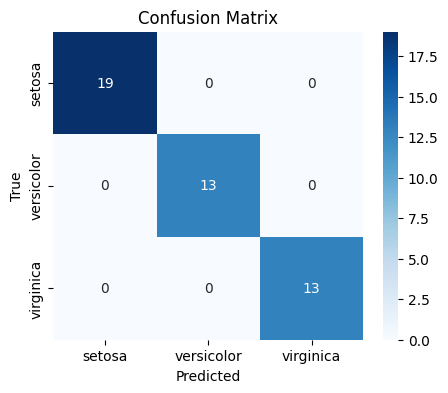


Confusion Matrix:
╒════════════╤══════════╤══════════════╤═════════════╕
│            │   setosa │   versicolor │   virginica │
╞════════════╪══════════╪══════════════╪═════════════╡
│ setosa     │       19 │            0 │           0 │
├────────────┼──────────┼──────────────┼─────────────┤
│ versicolor │        0 │           13 │           0 │
├────────────┼──────────┼──────────────┼─────────────┤
│ virginica  │        0 │            0 │          13 │
╘════════════╧══════════╧══════════════╧═════════════╛


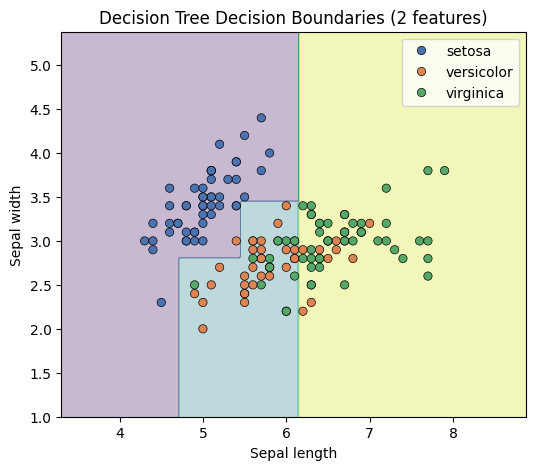

In [56]:
# Reload data (reuse function)
X_train, X_test, y_train, y_test = makedata_iris()

# Train tree again for visualization
clf = DecisionTreeClassifier(max_depth=3, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Classification Report
report_dict = classification_report(
    y_test, y_pred, target_names=load_iris().target_names, output_dict=True
)

report_table = []
for label, metrics in report_dict.items():
    if isinstance(metrics, dict):
        row = [
            label,
            metrics["precision"],
            metrics["recall"],
            metrics["f1-score"],
            metrics["support"],
        ]
        report_table.append(row)

print("\nClassification Report:")
print(
    tabulate(
        report_table,
        headers=["Class", "Precision", "Recall", "F1-Score", "Support"],
        floatfmt=".2f",
        tablefmt="fancy_grid",
    )
)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    cmap="Blues",
    fmt="d",
    xticklabels=load_iris().target_names,
    yticklabels=load_iris().target_names,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Confusion Matrix as table
labels = load_iris().target_names
cm_table = []
header = [""] + list(labels)
for i, row in enumerate(cm):
    cm_table.append([labels[i]] + list(row))

print("\nConfusion Matrix:")
print(tabulate(cm_table, headers=header, tablefmt="fancy_grid"))

# Decision Boundary Visualization
# Take only first two features (for 2D plotting)
X = load_iris().data[:, :2]
y = load_iris().target

# Train tree with 2 features for visualization
clf_vis = DecisionTreeClassifier(max_depth=3, random_state=0)
clf_vis.fit(X, y)

# Plot decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02)
)

Z = clf_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, Z, alpha=0.3)
sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=load_iris().target_names[y],
    palette="deep",
    edgecolor="k",
)
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")
plt.title("Decision Tree Decision Boundaries (2 features)")
plt.show()


### **Question 2.1 Observation**
The **decision tree classifier** achieved perfect accuracy on the test data, with precision, recall, and F1-scores all at 1.00. The **confusion matrix** shows no misclassifications, and the tabulated classification report confirms the model is handling all three classes equally well.

From the decision boundaries, it’s clear that **setosa is completely separated** by sepal length, which is an easy split for the tree. **Versicolor and virginica**, which overlap more, are not separated as cleanly here. There ared jagged, rectangular cuts that reflect the tree’s hierarchical rules.

The results demonstrate how well a tree can fit this dataset. However, this plus the perfect scores also suggest caution: such performance may not generalize as cleanly on larger, noisier, or less distinct data.

## **Question 2.2 Interpretability of Decision Trees** 

A great advantage of decision trees is their **interpretability**, i.e., the ability to understand **how and why a classifier made its decision**.  
We will demonstrate this in two steps:  

- **2.2.1**: Extending the predict function with explanations (decision path).  
- **2.2.2**: Displaying the learnt tree itself as a visualization and a text "rulebook".  


### **Question 2.2.1 Predict Function with Explanations**

We extend the classifier with a function that, in addition to predicting the class, prints the **sequence of feature-based conditions** that led to the classification.  

In [57]:
# Function to predict with explanation
def predict_with_explanation(clf, X, feature_names, target_names):
    """
    Predict with explanation: prints decision path for each sample.
    """
    tree = clf.tree_

    # Recursive function to explain decision path
    def explain(sample, node=0, depth=0):
        indent = "  " * depth
        if tree.feature[node] != _tree.TREE_UNDEFINED:
            feature = feature_names[tree.feature[node]]
            threshold = tree.threshold[node]
            if sample[tree.feature[node]] <= threshold:
                print(f"{indent}if {feature} <= {threshold:.2f}:")
                return explain(sample, tree.children_left[node], depth + 1)
            else:
                print(f"{indent}if {feature} > {threshold:.2f}:")
                return explain(sample, tree.children_right[node], depth + 1)
        else:
            # Leaf node
            class_idx = np.argmax(tree.value[node])
            print(f"{indent}--> Predict: {target_names[class_idx]}")
            return target_names[class_idx]

    results = []
    for i, sample in enumerate(X):
        print(f"\nSample {i}:")
        results.append(explain(sample))
    return results


# Train tree on full dataset for interpretability
iris = load_iris()
clf = DecisionTreeClassifier(max_depth=3, random_state=0)
clf.fit(iris.data, iris.target)

# Pick a few test samples
X_test_samples = iris.data[[0, 50, 100]]
y_test_samples = iris.target[[0, 50, 100]]

# Run predictions with explanation
predictions = predict_with_explanation(clf, X_test_samples, iris.feature_names, iris.target_names)



Sample 0:
if petal width (cm) <= 0.80:
  --> Predict: setosa

Sample 1:
if petal width (cm) > 0.80:
  if petal width (cm) <= 1.75:
    if petal length (cm) <= 4.95:
      --> Predict: versicolor

Sample 2:
if petal width (cm) > 0.80:
  if petal width (cm) > 1.75:
    if petal length (cm) > 4.85:
      --> Predict: virginica


### Observation

The tree breaks down the prediction into very simple thresholds on petal length and petal width. The first split is on **petal width ≤ 0.8**, which cleanly separates setosa from the other two species. The second split then distinguishes versicolor from virginica based on **petal length**. These rules are straightforward enough that even someone in the field could apply them manually to identify an iris species. The step-like logic also makes it clear why decision trees are considered highly interpretable.


In [58]:
# Train a simple tree on the full dataset
iris = load_iris()
X, y = iris.data, iris.target
clf_simple = DecisionTreeClassifier(max_depth=3, random_state=0)
clf_simple.fit(X, y)

# Print the whole tree in human-readable text
tree_rules = export_text(clf_simple, feature_names=iris.feature_names)
print("Learned decision rules:\n")
print(tree_rules)

# Show how a few samples follow these rules
print("\n Sample Explanations")
for i in range(3):  # explain first 3 test samples
    sample = X[i].reshape(1, -1)
    pred = clf_simple.predict(sample)[0]
    print(f"Sample {i}: {iris.target_names[pred]}")


Learned decision rules:

|--- petal width (cm) <= 0.80
|   |--- class: 0
|--- petal width (cm) >  0.80
|   |--- petal width (cm) <= 1.75
|   |   |--- petal length (cm) <= 4.95
|   |   |   |--- class: 1
|   |   |--- petal length (cm) >  4.95
|   |   |   |--- class: 2
|   |--- petal width (cm) >  1.75
|   |   |--- petal length (cm) <= 4.85
|   |   |   |--- class: 2
|   |   |--- petal length (cm) >  4.85
|   |   |   |--- class: 2


 Sample Explanations
Sample 0: setosa
Sample 1: setosa
Sample 2: setosa


### **Observation**
The learned tree shows that petal width is the first and most decisive feature. A threshold of 0.8 immediately separates setosa (class 0) from the others. For samples with wider petals, the tree checks petal length to split versicolor (class 1) from virginica (class 2).

However, looking at the sample explanations, the classifier predicted setosa for the first three samples. This is expected because the first rows in the dataset are all setosa flowers. It confirms the tree rules are consistent with the data order; the initial split on petal width ≤ 0.8 drives these predictions.

The main takeaway is that the rules are simple and hierarchical: one threshold cleanly isolates setosa, while further splits distinguish versicolor and virginica.

### ** Question 2.2.2 Displaying the Learnt Tree** 

We can also display the learnt decision tree:  
- **Graphical form**: shows splits visually.  
- **Textual rules**: shows a concise human-readable "key" to identify species.  


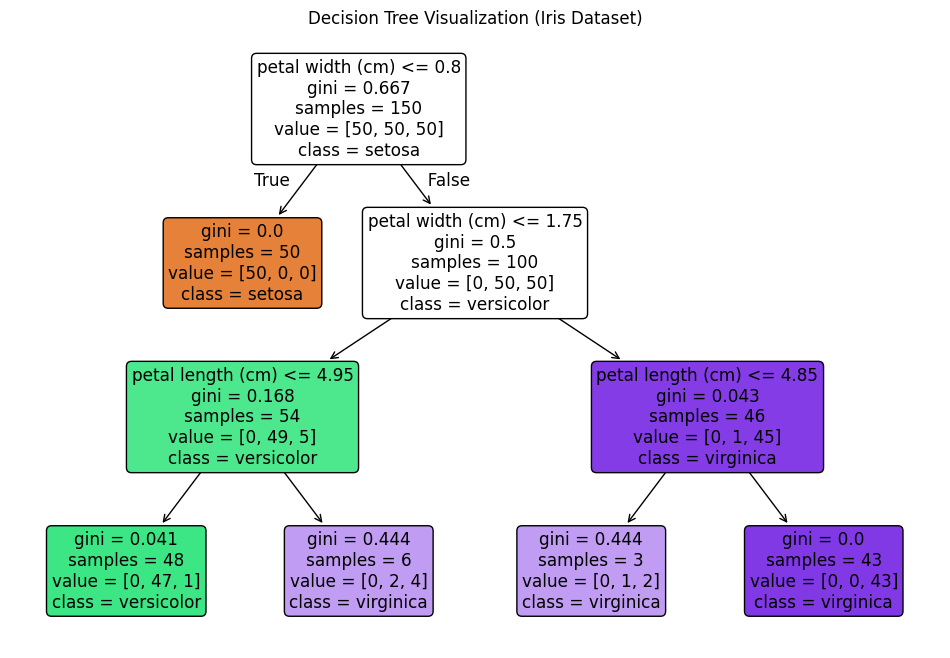


Decision Tree Rules (text format):
|--- petal width (cm) <= 0.80
|   |--- class: 0
|--- petal width (cm) >  0.80
|   |--- petal width (cm) <= 1.75
|   |   |--- petal length (cm) <= 4.95
|   |   |   |--- class: 1
|   |   |--- petal length (cm) >  4.95
|   |   |   |--- class: 2
|   |--- petal width (cm) >  1.75
|   |   |--- petal length (cm) <= 4.85
|   |   |   |--- class: 2
|   |   |--- petal length (cm) >  4.85
|   |   |   |--- class: 2



In [59]:
# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(
    clf,
    feature_names=iris.feature_names,
    class_names=iris.target_names,
    filled=True,
    rounded=True
)
plt.title("Decision Tree Visualization (Iris Dataset)")
plt.show()

# Textual representation
print("\nDecision Tree Rules (text format):")
tree_rules = export_text(clf, feature_names=iris.feature_names)
print(tree_rules)


### Observation (2.2.2)

The decision tree visualization makes the classifier’s logic fully transparent. At the root, *petal width ≤ 0.8* cleanly isolates all **Setosa** samples (pure class, gini=0). Beyond that, the tree continues splitting on **petal width** and **petal length**, gradually separating **Versicolor** from **Virginica**.

What stands out is how compact the rules are:

* *If petal width ≤ 0.8 → Setosa*
* *Else if petal length ≤ 4.95 → Versicolor*
* *Else → Virginica*

This confirms what we already observed in the text rules: **Setosa is trivial to identify**, while Versicolor and Virginica require additional conditions due to partial overlap. The leaf nodes also reveal sample counts and purity, showing that most branches lead to nearly homogeneous groups.

In short, the visualization demonstrates the **interpretability advantage** of decision trees: the splits are intuitive, feature-based, and readable like a botanical key that a human expert could directly apply.

### ** Question 3.1 SciKit-learn Classifiers: Key Parameters**

- **K-Nearest Neighbours (KNN)**  
  * `n_neighbors` → number of neighbours to consider (theoretical: controls bias-variance tradeoff; small k → low bias, high variance, large k → high bias, low variance)  
  * `weights` → how neighbours vote (`uniform` or `distance`)  
  * `metric` → distance metric for similarity (e.g., Euclidean)  

- **Logistic Regression**  
  * `penalty` → regularization type (L1, L2, none)  
  * `C` → inverse regularization strength (smaller C → stronger regularization)  
  * `solver` → optimization algorithm (e.g., `lbfgs`)  
  * `multi_class` → how to handle multiclass (ovr = one-vs-rest, multinomial)  

- **Support Vector Classifier (SVC)**  
  * `C` → regularization parameter (soft margin; controls tradeoff between margin size and misclassification)  
  * `kernel` → function defining similarity (linear, poly, rbf, etc.)  
  * `gamma` → kernel coefficient (for rbf/poly kernels; influences shape of decision boundary)  
  * `degree` → polynomial degree (for poly kernel)  